In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as Spline


In [2]:
# Input and output k vector
kk  = np.logspace(-4.0,3.0,2000)
kout = np.arange(0,0.5,0.01)

In [3]:
# Window Function
win = np.loadtxt('/global/cscratch1/sd/sfschen/fit_eboss/data/lrg_elg_qso/LRG_Pk/Window_LRGPk_NGC_0.6z1.0.txt')

rwin, w0, w2, w4, w6, w8 = win[:,0], win[:,1], win[:,2], win[:,3], win[:,4], win[:,5]
w0 /= w0[0]
w2 /= w0[0]
w4 /= w0[0]
w6 /= w0[0]
w8 /= w0[0]

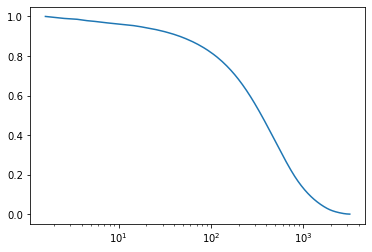

In [4]:
plt.semilogx(rwin, w0)

In [5]:
# Approximate Input as a step function
ii = 900
pvec = np.zeros_like(kk); pvec[ii] = 1

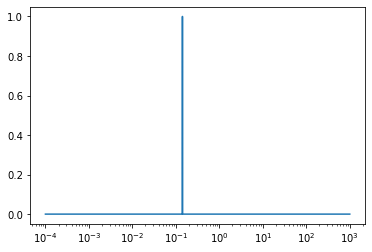

In [6]:
plt.plot(kk, pvec)

plt.xscale('log')

In [7]:
# Now see what happens when we Hankel transform and bin (ideal window)
import sys
sys.path.append('/global/u1/s/sfschen/Python/velocileptors/')

from velocileptors.Utils.spherical_bessel_transform import SphericalBesselTransform
from velocileptors.Utils.loginterp import loginterp

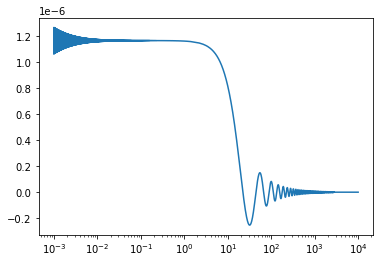

In [8]:
sbt   = SphericalBesselTransform(kk,fourier=True)
q0,xi0= sbt.sph(0,pvec)
plt.semilogx(q0,xi0)

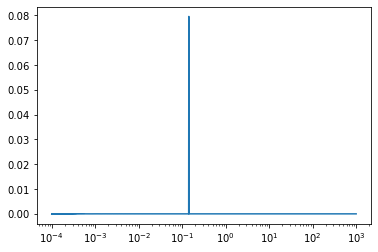

In [9]:
#w0 = loginterp(rwin,w0)(q0)
w0 = Spline(rwin,w0,ext=3)(q0)

sbt  = SphericalBesselTransform(q0,fourier=False)
kk,pk   = sbt.sph(0,xi0)
plt.semilogx(kk,pk)

In [10]:
thy0 = Spline(kk,pk,ext=1)
dx   = kout[1]-kout[0]
tmp0 = np.zeros_like(kout)

for i in range(kout.size):
    ss     = np.linspace(kout[i]-dx/2,kout[i]+dx/2,100)
    ivol   = 3.0/((kout[i]+dx/2)**3-(kout[i]-dx/2)**3)
    tmp0[i]= np.trapz(ss**2*thy0(ss),x=ss)*ivol

thy0 = tmp0

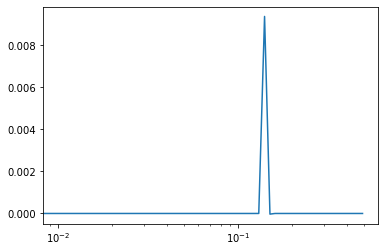

In [11]:
plt.semilogx(kout, thy0)

#plt.ylim(0,0.01)

In [12]:
# Try to do this systematically and build the matrix
mat = []

for ii, kin in enumerate(kk):
    #print(ii)
    pvec = np.zeros_like(kk); pvec[ii] = 1
    
    sbt   = SphericalBesselTransform(kk,fourier=True)
    q0,xi0= sbt.sph(0,pvec)
    #plt.semilogx(q0,xi0)
    
    sbt  = SphericalBesselTransform(q0,fourier=False)
    kk,pk   = sbt.sph(0,4*np.pi*xi0*w0)
    
    thy0 = Spline(kk,pk,ext=1)
    dx   = kout[1]-kout[0]
    tmp0 = np.zeros_like(kout)

    for i in range(kout.size):
        ss     = np.linspace(kout[i]-dx/2,kout[i]+dx/2,100)
        ivol   = 3.0/((kout[i]+dx/2)**3-(kout[i]-dx/2)**3)
        tmp0[i]= np.trapz(ss**2*thy0(ss),x=ss)*ivol

    thy0 = tmp0
    
    mat += [ list(thy0), ]

In [13]:
mat = np.array(mat)

In [14]:
mat.shape

(2000, 50)

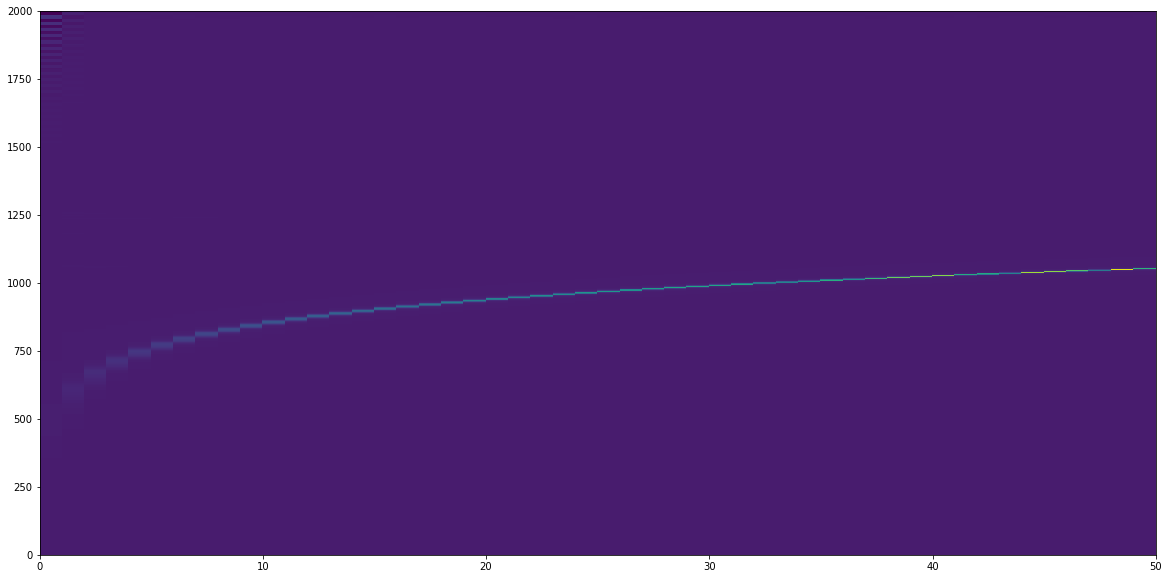

In [15]:
plt.figure(figsize=(20,10))

plt.pcolor(mat)

In [16]:
# Try a trial power spectrum:
ki, pi = np.loadtxt('../xFitter/fiducial_pk.txt', unpack=True)

pin = (loginterp(ki,pi)(kk) * (1 + 5 * kk**2) + 1000) * np.exp(-(0.1*kk)**2)

In [17]:
pout = np.dot(mat.T,pin)

(0.0, 0.5)

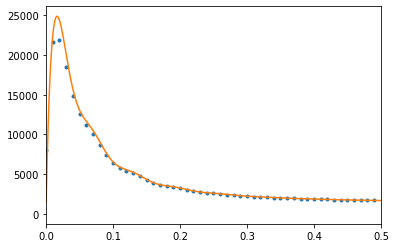

In [18]:
plt.plot(kout, pout, '.')
plt.plot(kk, pin)

plt.xlim(0,0.5)

(-0.01, 0.01)

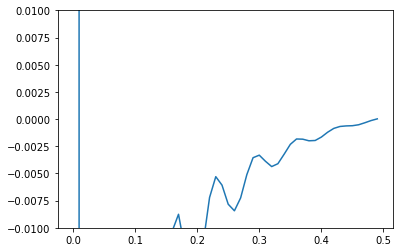

In [19]:
plt.plot(kout, pout/Spline(kk,pin)(kout) - 1)

plt.ylim(-0.01,0.01)

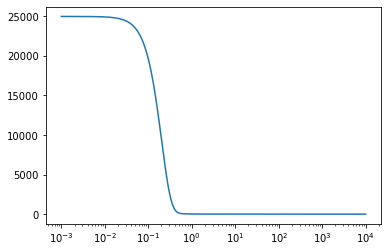

In [20]:
# Compare to straight Hankel transform and back:
sbt   = SphericalBesselTransform(kk,fourier=True)
q0,xi0= sbt.sph(0,pin)
plt.semilogx(q0,xi0)

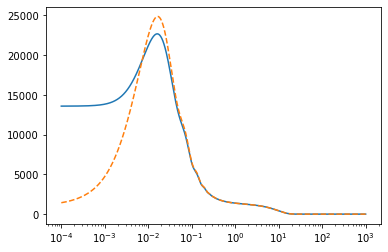

In [21]:
sbt  = SphericalBesselTransform(q0,fourier=False)
kk,pk   = sbt.sph(0,4*np.pi*xi0*w0)
plt.semilogx(kk,pk)
plt.plot(kk, pin, '--')

In [22]:
thy0 = Spline(kk,pk,ext=1)
dx   = kout[1]-kout[0]
tmp0 = np.zeros_like(kout)

for i in range(kout.size):
    ss     = np.linspace(kout[i]-dx/2,kout[i]+dx/2,100)
    ivol   = 3.0/((kout[i]+dx/2)**3-(kout[i]-dx/2)**3)
    tmp0[i]= np.trapz(ss**2*thy0(ss),x=ss)*ivol

thy0 = tmp0

(0.0, 0.5)

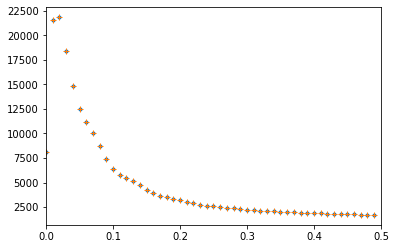

In [23]:
plt.plot(kout, pout, '.')
plt.plot(kout, thy0, '+')

plt.xlim(0,0.5)

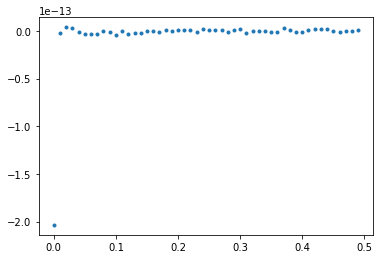

In [24]:
plt.plot(kout, pout/thy0 - 1, '.')

In [25]:
# Do the anisotropic case:
# Try to do this systematically and build the matrix
mat = []

rwin, w0, w2, w4, w6, w8 = win[:,0], win[:,1], win[:,2], win[:,3], win[:,4], win[:,5]
w0 /= w0[0]
w2 /= w0[0]
w4 /= w0[0]
w6 /= w0[0]
w8 /= w0[0]

w0 = Spline(rwin,w0,ext=3)(q0)
w2 = Spline(rwin,w2,ext=1)(q0)
w4 = Spline(rwin,w4,ext=1)(q0)
w6 = Spline(rwin,w6,ext=1)(q0)
w8 = Spline(rwin,w8,ext=1)(q0)

# Now the data vector will be [p0, p2, p4]
nk  = len(kk)

kells = np.concatenate( (kk,)*3 )

for ii, kell in enumerate(kells):
    #print(ii)
    
    #
    pvec = np.zeros_like(kells); pvec[ii] = 1
    p0 = pvec[:nk]
    p2 = pvec[nk:2*nk]
    p4 = pvec[2*nk:]
    
    sbt   = SphericalBesselTransform(kk,fourier=True)
    q0,xi0= sbt.sph(0,p0)
    q2,xi2= sbt.sph(2,p2); xi2 = Spline(q2,xi2)(q0)
    q4,xi4= sbt.sph(4,p4); xi4 = Spline(q4,xi4)(q0)
    #plt.semilogx(q0,xi0)
    
    sbt  = SphericalBesselTransform(q0,fourier=False)
    
    xi0p   = xi0*w0 + 1./5.*xi2*w2  + 1./9.*xi4*w4
    xi2p   = xi0*w2 + xi2*(w0+2./7.*w2+2./7.*w4) + \
                xi4*(2./7.*w2+100./693.*w4 + 25./143.*w6)
    xi4p   = xi0*w4 + xi2*(18./35*w2 + 20./77*w4 + 45./143*w6)\
                 + xi4*(w0 + 20./77*w2 + 162./1001*w4 + 20./143*w6 + 490./2431*w8)
    
    k0,p0   = sbt.sph(0,4*np.pi*xi0p)
    k2,p2   = sbt.sph(2,4*np.pi*xi2p)
    k4,p4   = sbt.sph(4,4*np.pi*xi4p)
    
    thy0 = Spline(k0,p0,ext=1)
    thy2 = Spline(k2,p2,ext=1)
    thy4 = Spline(k4,p4,ext=1)
    dx   = kout[1]-kout[0]
    
    tmp0 = np.zeros_like(kout)
    tmp2 = np.zeros_like(kout)
    tmp4 = np.zeros_like(kout)

    for i in range(kout.size):
        ss     = np.linspace(kout[i]-dx/2,kout[i]+dx/2,100)
        ivol   = 3.0/((kout[i]+dx/2)**3-(kout[i]-dx/2)**3)
        
        tmp0[i]= np.trapz(ss**2*thy0(ss),x=ss)*ivol
        tmp2[i]= np.trapz(ss**2*thy2(ss),x=ss)*ivol
        tmp4[i]= np.trapz(ss**2*thy4(ss),x=ss)*ivol
    
    mat += [ list(tmp0) + list(tmp2) + list(tmp4), ]
    
mat = np.array(mat)

<ipython-input-26-8c7009b50a69>:1: RuntimeWarning: invalid value encountered in log
  plt.pcolor(np.log(mat))


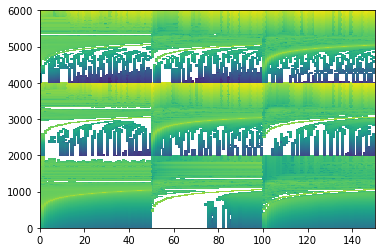

In [26]:
plt.pcolor(np.log(mat))

In [27]:
b = 1
f = 1
p0in = (b**2 + 2./3 * b*f + 1./5*f**2 ) * loginterp(ki,pi)(kk)
p2in = (4./3 * b*f + 4./7*f**2 ) * loginterp(ki,pi)(kk)
p4in = 8./35*f**2  * loginterp(ki,pi)(kk)

pvector = np.concatenate((p0in, p2in, p4in))
pout    = np.dot(mat.T, pvector)

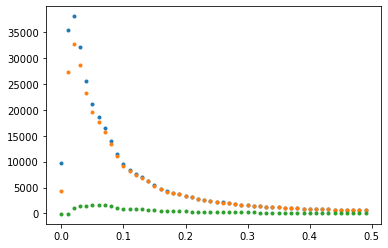

In [28]:
plt.plot(kout, pout[:50], '.')
plt.plot(kout, pout[50:100], '.')
plt.plot(kout, pout[100:150], '.')

In [29]:
# Compare to the one step computation:
rwin, w0, w2, w4, w6, w8 = win[:,0], win[:,1], win[:,2], win[:,3], win[:,4], win[:,5]
w0 /= w0[0]
w2 /= w0[0]
w4 /= w0[0]
w6 /= w0[0]
w8 /= w0[0]

w0 = Spline(rwin,w0,ext=3)(q0)
w2 = Spline(rwin,w2,ext=1)(q0)
w4 = Spline(rwin,w4,ext=1)(q0)
w6 = Spline(rwin,w6,ext=1)(q0)
w8 = Spline(rwin,w8,ext=1)(q0)

p0 = p0in
p2 = p2in
p4 = p4in
    
sbt   = SphericalBesselTransform(kk,fourier=True)
q0,xi0= sbt.sph(0,p0)
q2,xi2= sbt.sph(2,p2); xi2 = Spline(q2,xi2)(q0)
q4,xi4= sbt.sph(4,p4); xi4 = Spline(q4,xi4)(q0)

    
sbt  = SphericalBesselTransform(q0,fourier=False)
    
xi0p   = xi0*w0 + 1./5.*xi2*w2  + 1./9.*xi4*w4
xi2p   = xi0*w2 + xi2*(w0+2./7.*w2+2./7.*w4) + \
                xi4*(2./7.*w2+100./693.*w4 + 25./143.*w6)
xi4p   = xi0*w4 + xi2*(18./35*w2 + 20./77*w4 + 45./143*w6)\
                 + xi4*(w0 + 20./77*w2 + 162./1001*w4 + 20./143*w6 + 490./2431*w8)
    
k0,p0   = sbt.sph(0,4*np.pi*xi0p)
k2,p2   = sbt.sph(2,4*np.pi*xi2p)
k4,p4   = sbt.sph(4,4*np.pi*xi4p)
    
thy0 = Spline(k0,p0,ext=1)
thy2 = Spline(k2,p2,ext=1)
thy4 = Spline(k4,p4,ext=1)
dx   = kout[1]-kout[0]
    
tmp0 = np.zeros_like(kout)
tmp2 = np.zeros_like(kout)
tmp4 = np.zeros_like(kout)

for i in range(kout.size):
    ss     = np.linspace(kout[i]-dx/2,kout[i]+dx/2,100)
    ivol   = 3.0/((kout[i]+dx/2)**3-(kout[i]-dx/2)**3)
        
    tmp0[i]= np.trapz(ss**2*thy0(ss),x=ss)*ivol
    tmp2[i]= np.trapz(ss**2*thy2(ss),x=ss)*ivol
    tmp4[i]= np.trapz(ss**2*thy4(ss),x=ss)*ivol
    
ponce = np.concatenate((tmp0,tmp2,tmp4))

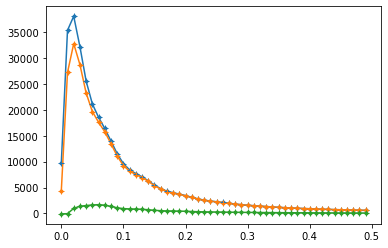

In [30]:
plt.plot(kout, pout[:50], 'C0.-')
plt.plot(kout, pout[50:100], 'C1.-')
plt.plot(kout, pout[100:], 'C2.-')

plt.plot(kout, ponce[:50], 'C0+')
plt.plot(kout, ponce[50:100], 'C1+')
plt.plot(kout, ponce[100:150], 'C2+')

In [1]:
plt.plot(kout, pout[:50]/ponce[:50] - 1, 'C0')
plt.plot(kout, pout[50:100]/pout[50:100] - 1, 'C1')
plt.plot(kout, pout[100:150]/pout[100:150] - 1, 'C2')

NameError: name 'plt' is not defined

In [32]:
# Test the module:
import numpy as np
from make_window_matrix import make_window_matrix

In [44]:
win = np.loadtxt('/global/cscratch1/sd/sfschen/fit_eboss/data/lrg_elg_qso/LRG_Pk/Window_LRGPk_NGC_0.6z1.0.txt')
rwin, w0, w2, w4, w6, w8 = win[:,0], win[:,1], win[:,2], win[:,3], win[:,4], win[:,5]

rwin, w0, w2, w4, w6, w8 = win[:,0], win[:,1], win[:,2], win[:,3], win[:,4], win[:,5]
w0 /= w0[0]
w2 /= w0[0]
w4 /= w0[0]
w6 /= w0[0]
w8 /= w0[0]

window_matrix = make_window_matrix((rwin,w0,w2,w4,w6,w8))

In [45]:
window_matrix/mat

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.00003727, 0.99999064, 0.99999551, ..., 1.        , 0.99999999,
        1.        ],
       [0.99999048, 1.00001526, 1.00000906, ..., 1.00000001, 0.99999999,
        1.        ],
       [1.00003731, 0.99997459, 1.00002061, ..., 0.99999999, 1.        ,
        1.        ]])

In [46]:
pmod = np.dot(window_matrix.T, pvector)

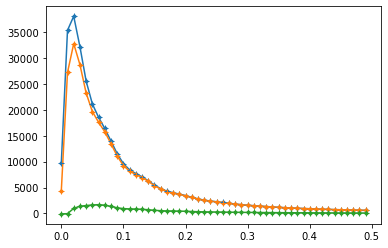

In [47]:
plt.plot(kout, pout[:50], 'C0.-')
plt.plot(kout, pout[50:100], 'C1.-')
plt.plot(kout, pout[100:], 'C2.-')

plt.plot(kout, pmod[:50], 'C0+')
plt.plot(kout, pmod[50:100], 'C1+')
plt.plot(kout, pmod[100:150], 'C2+')

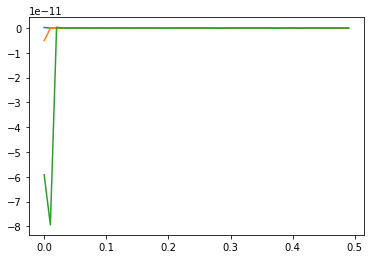

In [49]:
plt.plot(kout, pout[:50]/pmod[:50] - 1, 'C0')
plt.plot(kout, pout[50:100]/pmod[50:100] - 1, 'C1')
plt.plot(kout, pout[100:150]/pmod[100:150] - 1, 'C2')